In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf 'drive/MyDrive/BMI707/OCT2017.tar.gz' -C './'

In [ ]:
import imageio as iio
import os
import numpy as np
import seaborn as sns
import cv2
import skimage
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
training_size = 4000
num_class = 4

imageSize=224
train_dir = "./OCT2017/train/"
test_dir =  "./OCT2017/test/"

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                raise ValueError('Unknown label: ' + folderName)
            for image_filename in tqdm(os.listdir(folder + folderName)[:int(training_size/num_class)]):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

100%|██████████| 250/250 [00:06<00:00, 36.73it/s]


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        self.attention_weights = None

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        depth = tf.cast(tf.shape(k)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        if mask is not None:
            logits += (mask * -1e9)
        self.attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(self.attention_weights, v)
        return output

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output

class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, name, rate=0.1):
        super(TransformerLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = self.point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self._name = name

    def point_wise_feed_forward_network(self, d_model, dff):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

    def call(self, x, mask=None):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

def get_positional_encoding(seq_length, d_model):
    pos = np.arange(seq_length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
vgg.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def create_model(d_model, patch_size):
    inputs = tf.keras.Input(shape=(224, 224, 3), name="Input")
    seq_length = (1 + ((224 - patch_size))//patch_size)  ** 2
    pos_enc = get_positional_encoding(seq_length, d_model)
    # x = tf.keras.layers.Conv2D(d_model, (patch_size, patch_size),
    #                            strides=patch_size,
    #                            activation='relu', name="Conv0")(inputs)
    x = tf.keras.models.Model(inputs=vgg.layers[0].input, outputs=vgg.layers[11].output, name="VGG")(inputs)
    x = tf.keras.layers.Reshape((seq_length, d_model), name="Reshape")(x)
    x = tf.keras.layers.Add(name="Add")([x, pos_enc])
    x = TransformerLayer(d_model, 16, 512, name="Transformer0")(x)
    x = TransformerLayer(d_model, 16, 512, name="Transformer1")(x)
    x = TransformerLayer(d_model, 16, 512, name="Transformer2")(x)
    x = tf.keras.layers.Conv1D(4, 1, activation='sigmoid', name="ConvWeight")(x)

    # x = tf.keras.layers.Dense(64, activation='relu', name="FCN0")(x)
    # outputs = tf.keras.layers.Dense(4, activation='softmax', name="Output")(x)
    x = tf.keras.layers.GlobalMaxPool1D(name="GlobalPooling")(x)
    # x = tf.keras.layers.Flatten(name="Flatten")(x)
    outputs = tf.keras.layers.Activation(activation="softmax",name="Output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MIL")
    model.layers[1].trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [ ]:
model = create_model(d_model=256, patch_size=8)
model.summary()

Model: "MIL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 VGG (Functional)            (None, 28, 28, 256)       2325568   
                                                                 
 Reshape (Reshape)           (None, 784, 256)          0         
                                                                 
 Add (Add)                   (None, 784, 256)          0         
                                                                 
 Transformer0 (TransformerL  (None, 784, 256)          527104    
 ayer)                                                           
                                                                 
 Transformer1 (TransformerL  (None, 784, 256)          527104    
 ayer)                                                         

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
125/125 [==============================] - 78s 562ms/step - loss: 1.3373 - accuracy: 0.3120 - val_loss: 1.1317 - val_accuracy: 0.6220
Epoch 2/20
125/125 [==============================] - 69s 550ms/step - loss: 1.0743 - accuracy: 0.6553 - val_loss: 0.9080 - val_accuracy: 0.8460
Epoch 3/20
125/125 [==============================] - 69s 550ms/step - loss: 0.9459 - accuracy: 0.7837 - val_loss: 0.8170 - val_accuracy: 0.9300
Epoch 4/20
125/125 [==============================] - 69s 550ms/step - loss: 0.9084 - accuracy: 0.8223 - val_loss: 0.8115 - val_accuracy: 0.9280
Epoch 5/20
125/125 [==============================] - 69s 550ms/step - loss: 0.8828 - accuracy: 0.8547 - val_loss: 0.7987 - val_accuracy: 0.9370
Epoch 6/20
125/125 [==============================] - 69s 550ms/step - loss: 0.8724 - accuracy: 0.8537 - val_loss: 0.8033 - val_accuracy: 0.9340
Epoch 7/20
125/125 [==============================] - 69s 550ms/step - loss: 0.8552 - accuracy: 0.8792 - val_loss: 0.7918 - val_ac

In [ ]:
y_pred = model.predict(X_test)

32/32 [==============================] - 8s 228ms/step


In [ ]:
def plot_learning_curve(train_scores, val_scores, metric, title=None, ylim=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.plot(range(len(train_scores)), train_scores, '-', color="r",
             label=f"Training {metric}")
    plt.plot(range(len(val_scores)), val_scores, '-', color="g",
             label=f"Validation {metric}")

    plt.legend(loc="best")
    plt.show()

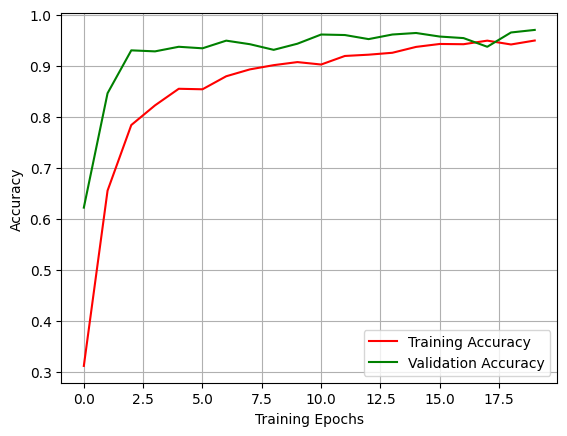

In [ ]:
plot_learning_curve(history.history['accuracy'], history.history['val_accuracy'], metric="Accuracy")

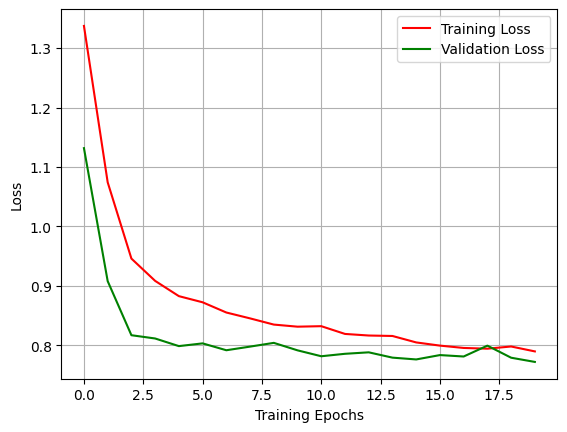

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], metric="Loss")

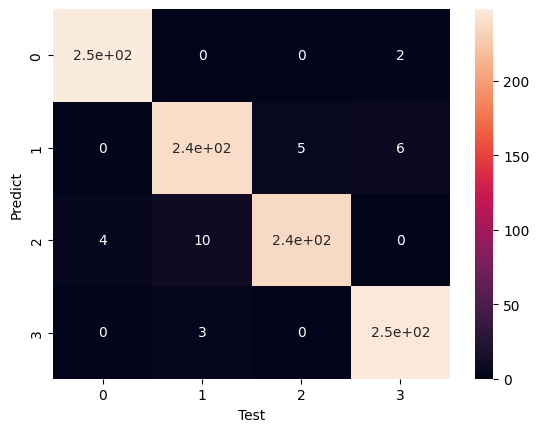

              precision    recall  f1-score   support

           0      0.984     0.992     0.988       250
           1      0.948     0.956     0.952       250
           2      0.979     0.944     0.961       250
           3      0.969     0.988     0.978       250

    accuracy                          0.970      1000
   macro avg      0.970     0.970     0.970      1000
weighted avg      0.970     0.970     0.970      1000



In [ ]:
sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred, axis=1)), annot=True)
plt.xlabel('Test')
plt.ylabel('Predict')
plt.show()
print(classification_report(y_test, np.argmax(y_pred, axis=1), digits=3))

In [ ]:
weight_loader = tf.keras.models.Model(model.layers[0].input, model.layers[7].output)

In [ ]:
index = 1011
img_weights = weight_loader.predict(X_train[index:index+1], verbose=0)
img_weights = img_weights.reshape((28, 28, 4))
# img_weights = np.apply_along_axis(cmyk_to_rgb, 1, img_weights)
# img_weights = img_weights.reshape(28,28,3)
test_img = np.copy(X_train[index])

<Axes: >

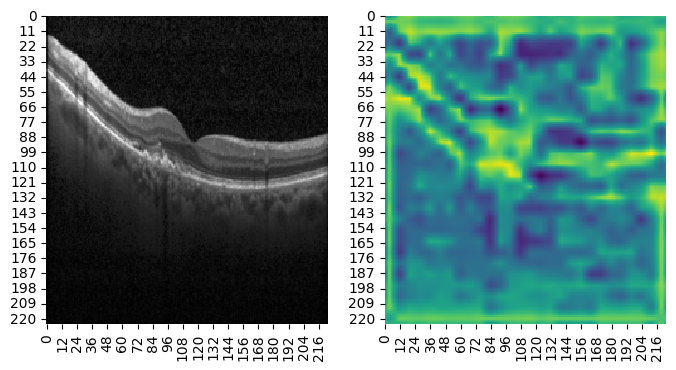

In [ ]:
# img_weights_display = skimage.transform.resize(img_weights[:,:,2], (imageSize, imageSize))
img_weights_display = skimage.transform.resize(img_weights[:,:,y_train[index]], (imageSize, imageSize))

fig, ax = plt.subplots(1, 2, figsize=(8,4))
sns.heatmap(test_img[:,:,0], ax=ax[0], cmap="Greys_r", cbar=False)
sns.heatmap(-1*np.log(-1+1/img_weights_display), ax=ax[1], cmap="viridis", cbar=False)
# sns.heatmap(img_weights_display, ax=ax[1], cmap="viridis", cbar=False)



In [ ]:
import pandas as pd

In [ ]:
history_df = [history.history[x] for x in history.history]
history_df = pd.DataFrame(history_df, index=history.history.keys()).transpose()
history_df["Epoch"] = history_df.index+1
history_df.to_csv("toad_history.csv", index=False)

In [ ]:
model.save("AttnMIL.keras")